In [2]:
import pandas as pd
import plotnine as pn
from math import log10


###  Differentially Expressed Gene Scores Model

In [3]:
model_history_path = 'models/full_nn_5_updn_dropout_history.csv'
model_path = "models/full_nn_5_updn_dropout_nn_True.keras"

TypeError: melt() got an unexpected keyword argument 'tid_vars'

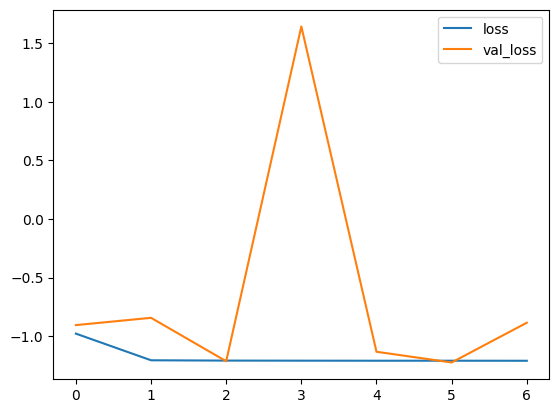

In [4]:
history = pd.read_csv(model_history_path, index_col=0)
history.loc[:, ['loss', 'val_loss']].map(log10).plot()
history.melt(tid_vars = 'Epoch')

## Loss onDn Differential Expression [Rerun on run 8]

In [111]:
# predicted_updn = pd.read_csv("intermediate_data/predicted_enrichments/predicted_updn/predicted_enrichments.csv", index_col = 0)
predicted_updn = pd.read_csv("intermediate_data/predicted_enrichments/predicted_updn_new/predicted_enrichments.csv", index_col = 0)
orig_updn = pd.read_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_enrichments.csv", index_col = 0)
spot_info_updn = pd.read_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_info.csv", index_col = 0) # SHOULD be identical

#### Residuals vs Predicted

In [112]:
predicted_updn['spot'] = list(predicted_updn.index)
tidy_predicted_updn = predicted_updn.melt(id_vars=['spot'], var_name='gene set', value_name='enrichment')
predicted_updn.drop(labels='spot', inplace = True, axis=1)

orig_updn['spot'] = list(orig_updn.index)
orig_updn = pd.concat([orig_updn, spot_info_updn], axis=1)
tidy_orig_updn = orig_updn.melt(id_vars=['spot'] + list(spot_info_updn.columns), var_name='gene set', value_name='enrichment')
orig_updn.drop(labels='spot', inplace = True, axis=1)

tidy_resids_updn = tidy_orig_updn.drop(['enrichment'], axis=1)
tidy_predicted_updn.loc[:,['spot', 'gene set']]
tidy_resids_updn['residual'] = tidy_orig_updn['enrichment'] - tidy_predicted_updn['enrichment']
tidy_resids_updn['predicted'] = tidy_predicted_updn['enrichment']
tidy_resids_updn['original'] = tidy_orig_updn['enrichment']

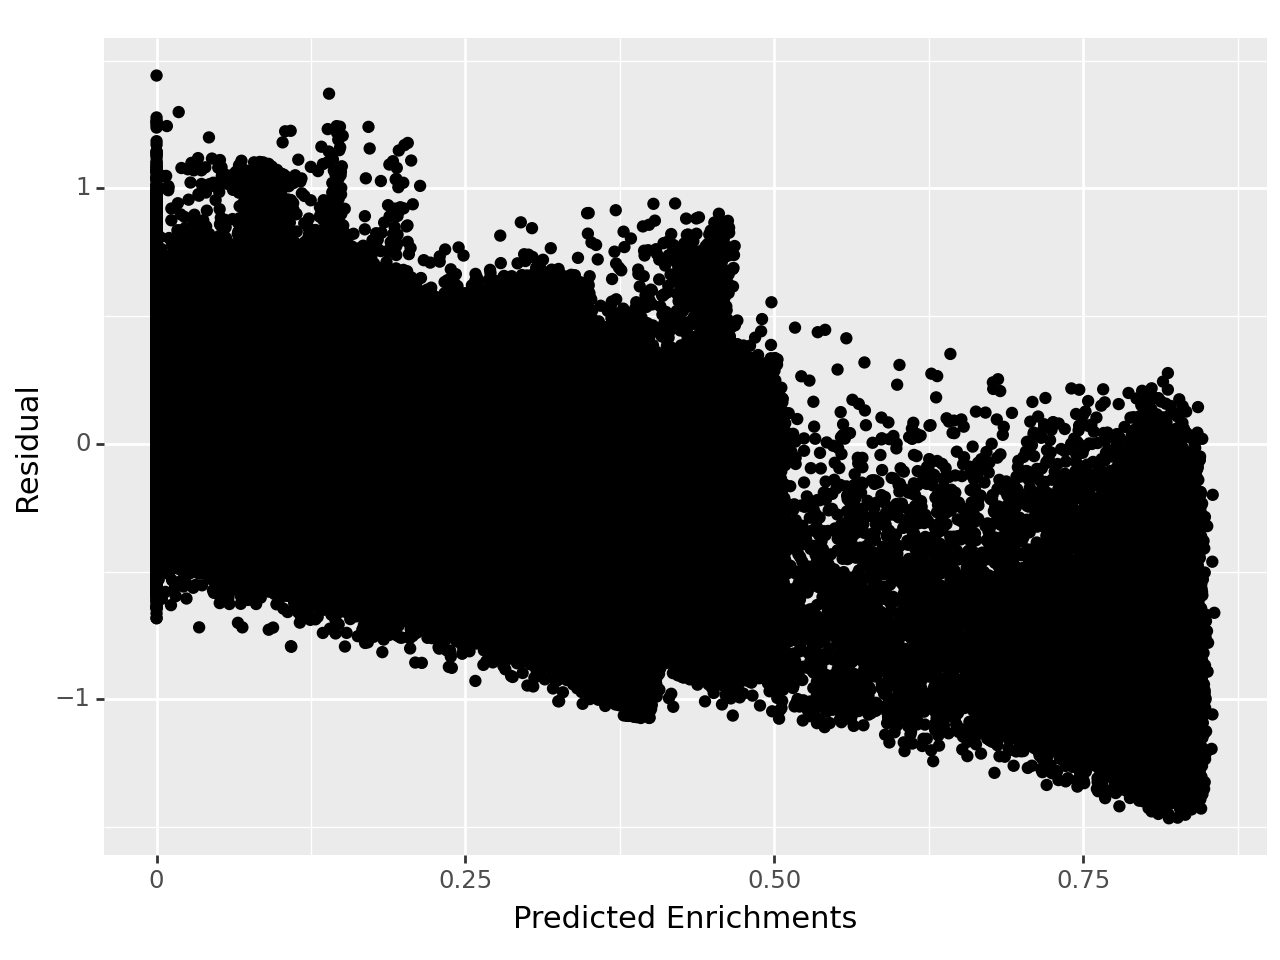

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(tidy_resids_updn, pn.aes(x = 'predicted', y = 'residual')) + 
        pn.geom_point() + 
        pn.xlab("Predicted Enrichments") + 
        pn.ylab("Residual")
)

In [113]:
# residuals_updn = predicted_updn - orig_updn
# residuals_updn = pd.concat([residuals_updn, spot_info_updn], axis=1) 
# residuals_updn.groupby('biopsy_sample_id', axis=0)
cat_order = pd.CategoricalDtype(['S2T1','S2T2','S7T1','S7T2','S8T1','S8T2','S8T3','S20T1','S20T2','S33T2',
     'S36T1','S36T2','S45T1','S46T2','S61T3'])
tidy_resids_updn['biopsy_sample_id']  = tidy_resids_updn['biopsy_sample_id'].astype(cat_order)
gs_cat_order = pd.CategoricalDtype(['S2T1 UP','S2T2 UP','S7T1 UP','S7T2 UP','S8T1 UP','S8T2 UP','S8T3 UP',
                                    'S20T1 UP','S20T2 UP','S33T2 UP','S36T1 UP','S36T2 UP','S45T1 UP','S46T2 UP',
                                    'S61T3 UP','S2T1 DN','S2T2 DN','S7T1 DN','S7T2 DN','S8T1 DN','S8T2 DN','S8T3 DN',
                                    'S20T1 DN','S20T2 DN','S33T2 DN','S36T1 DN','S36T2 DN','S45T1 DN','S46T2 DN','S61T3 DN'
                                    ], ordered= True)
tidy_resids_updn['gene set'] = tidy_resids_updn['gene set'].map(lambda x: x.split("_")[0] + " " + x.split("_")[-1].upper())
# tidy_resids_updn['gene set']
tidy_resids_updn['gene set']  = tidy_resids_updn['gene set'].astype(gs_cat_order)

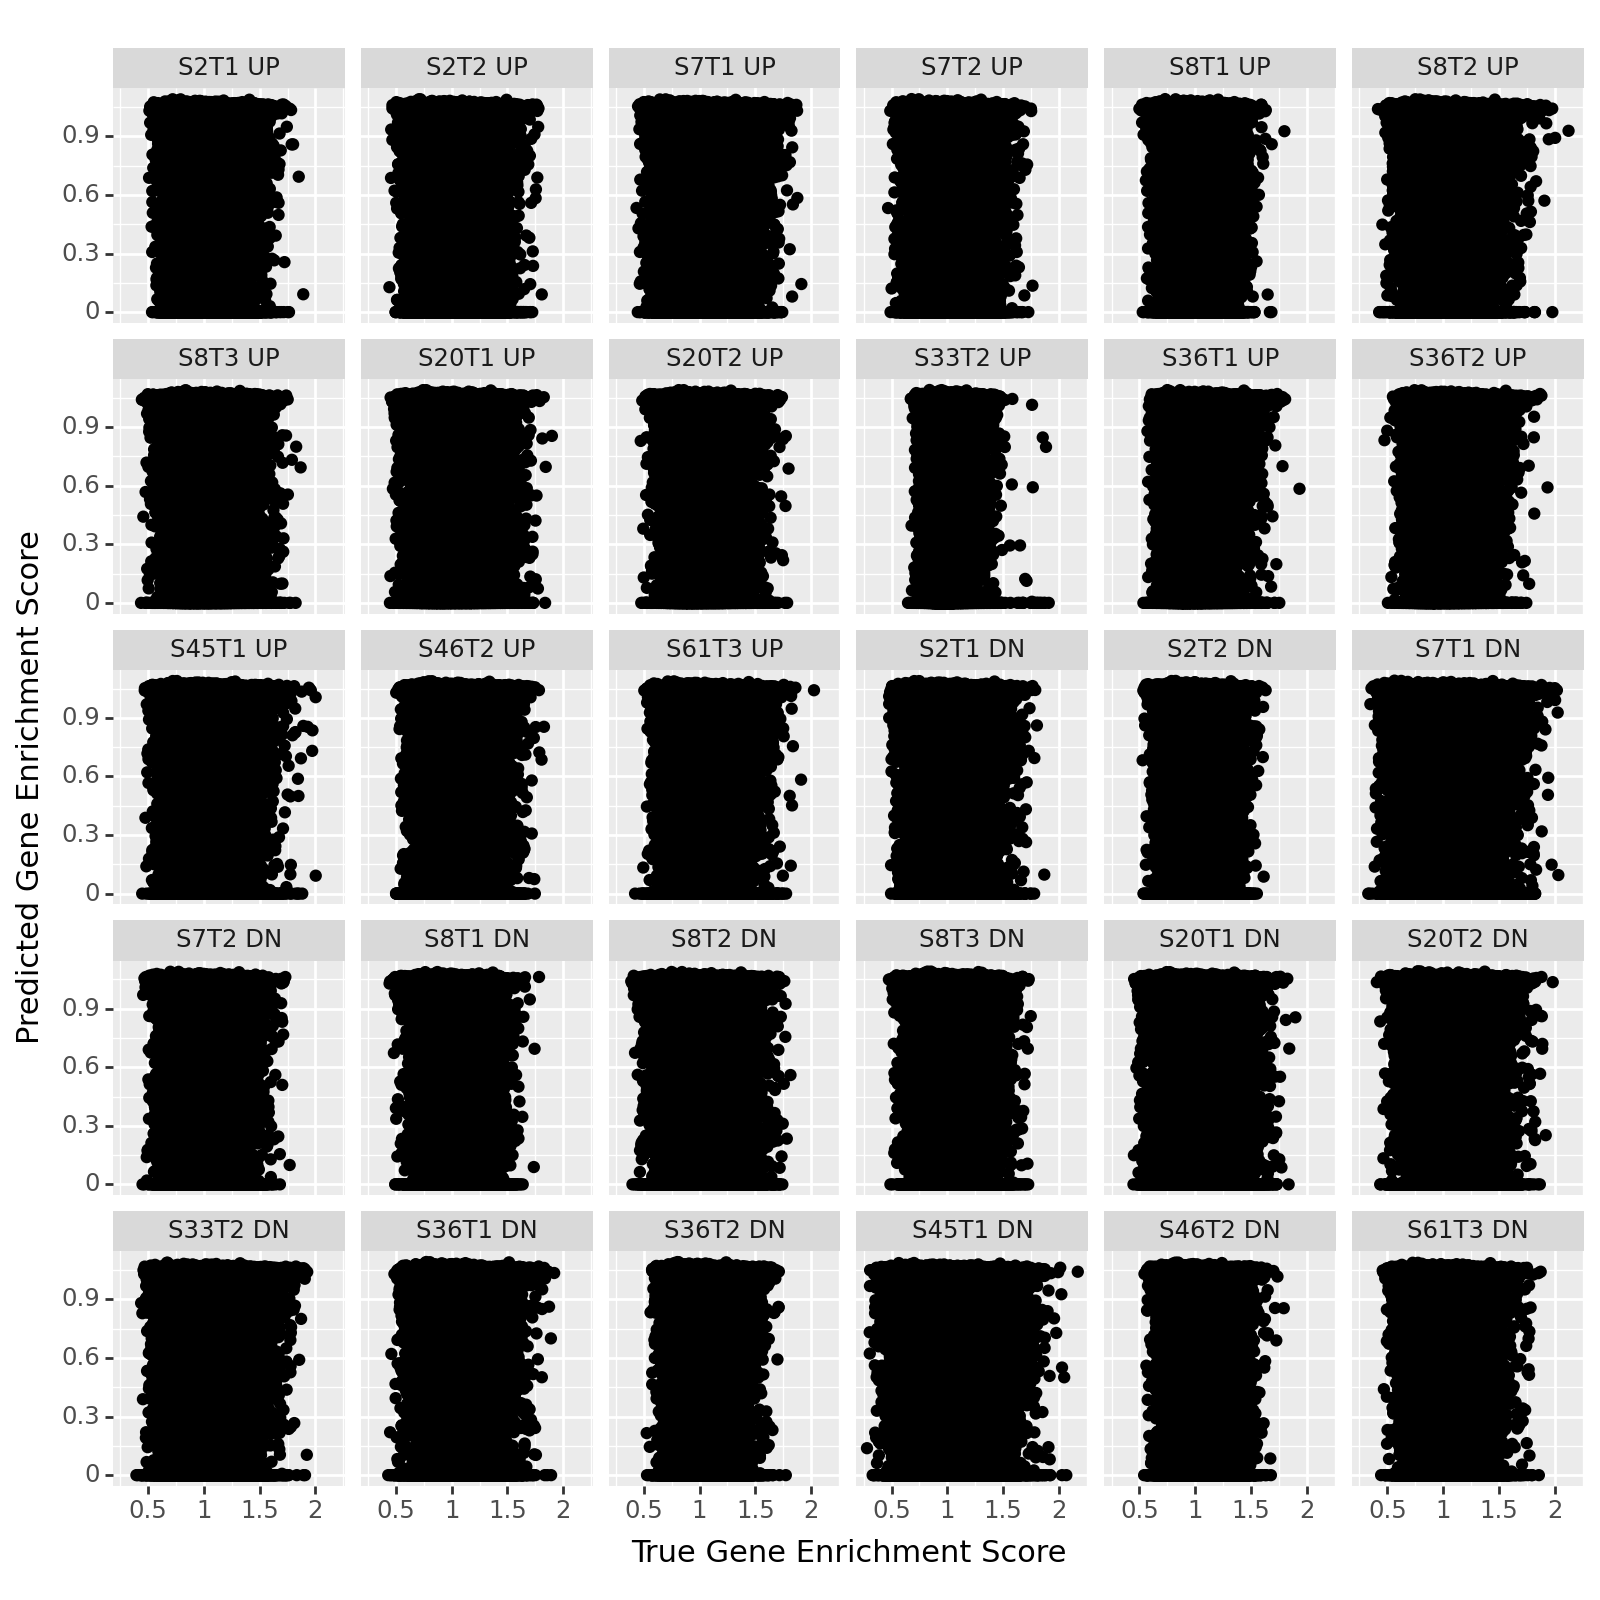

<Figure Size: (800 x 800)>

In [114]:
(
    pn.ggplot(tidy_resids_updn, pn.aes(x = 'original', y = 'predicted')) + 
        pn.geom_point() + 
        pn.xlab("True Gene Enrichment Score") + 
        pn.ylab("Predicted Gene Enrichment Score") +
        pn.facet_wrap('gene set') +
        # pn.theme_classic() + 
        pn.theme(figure_size=(8,8))
)

#### Loss by group

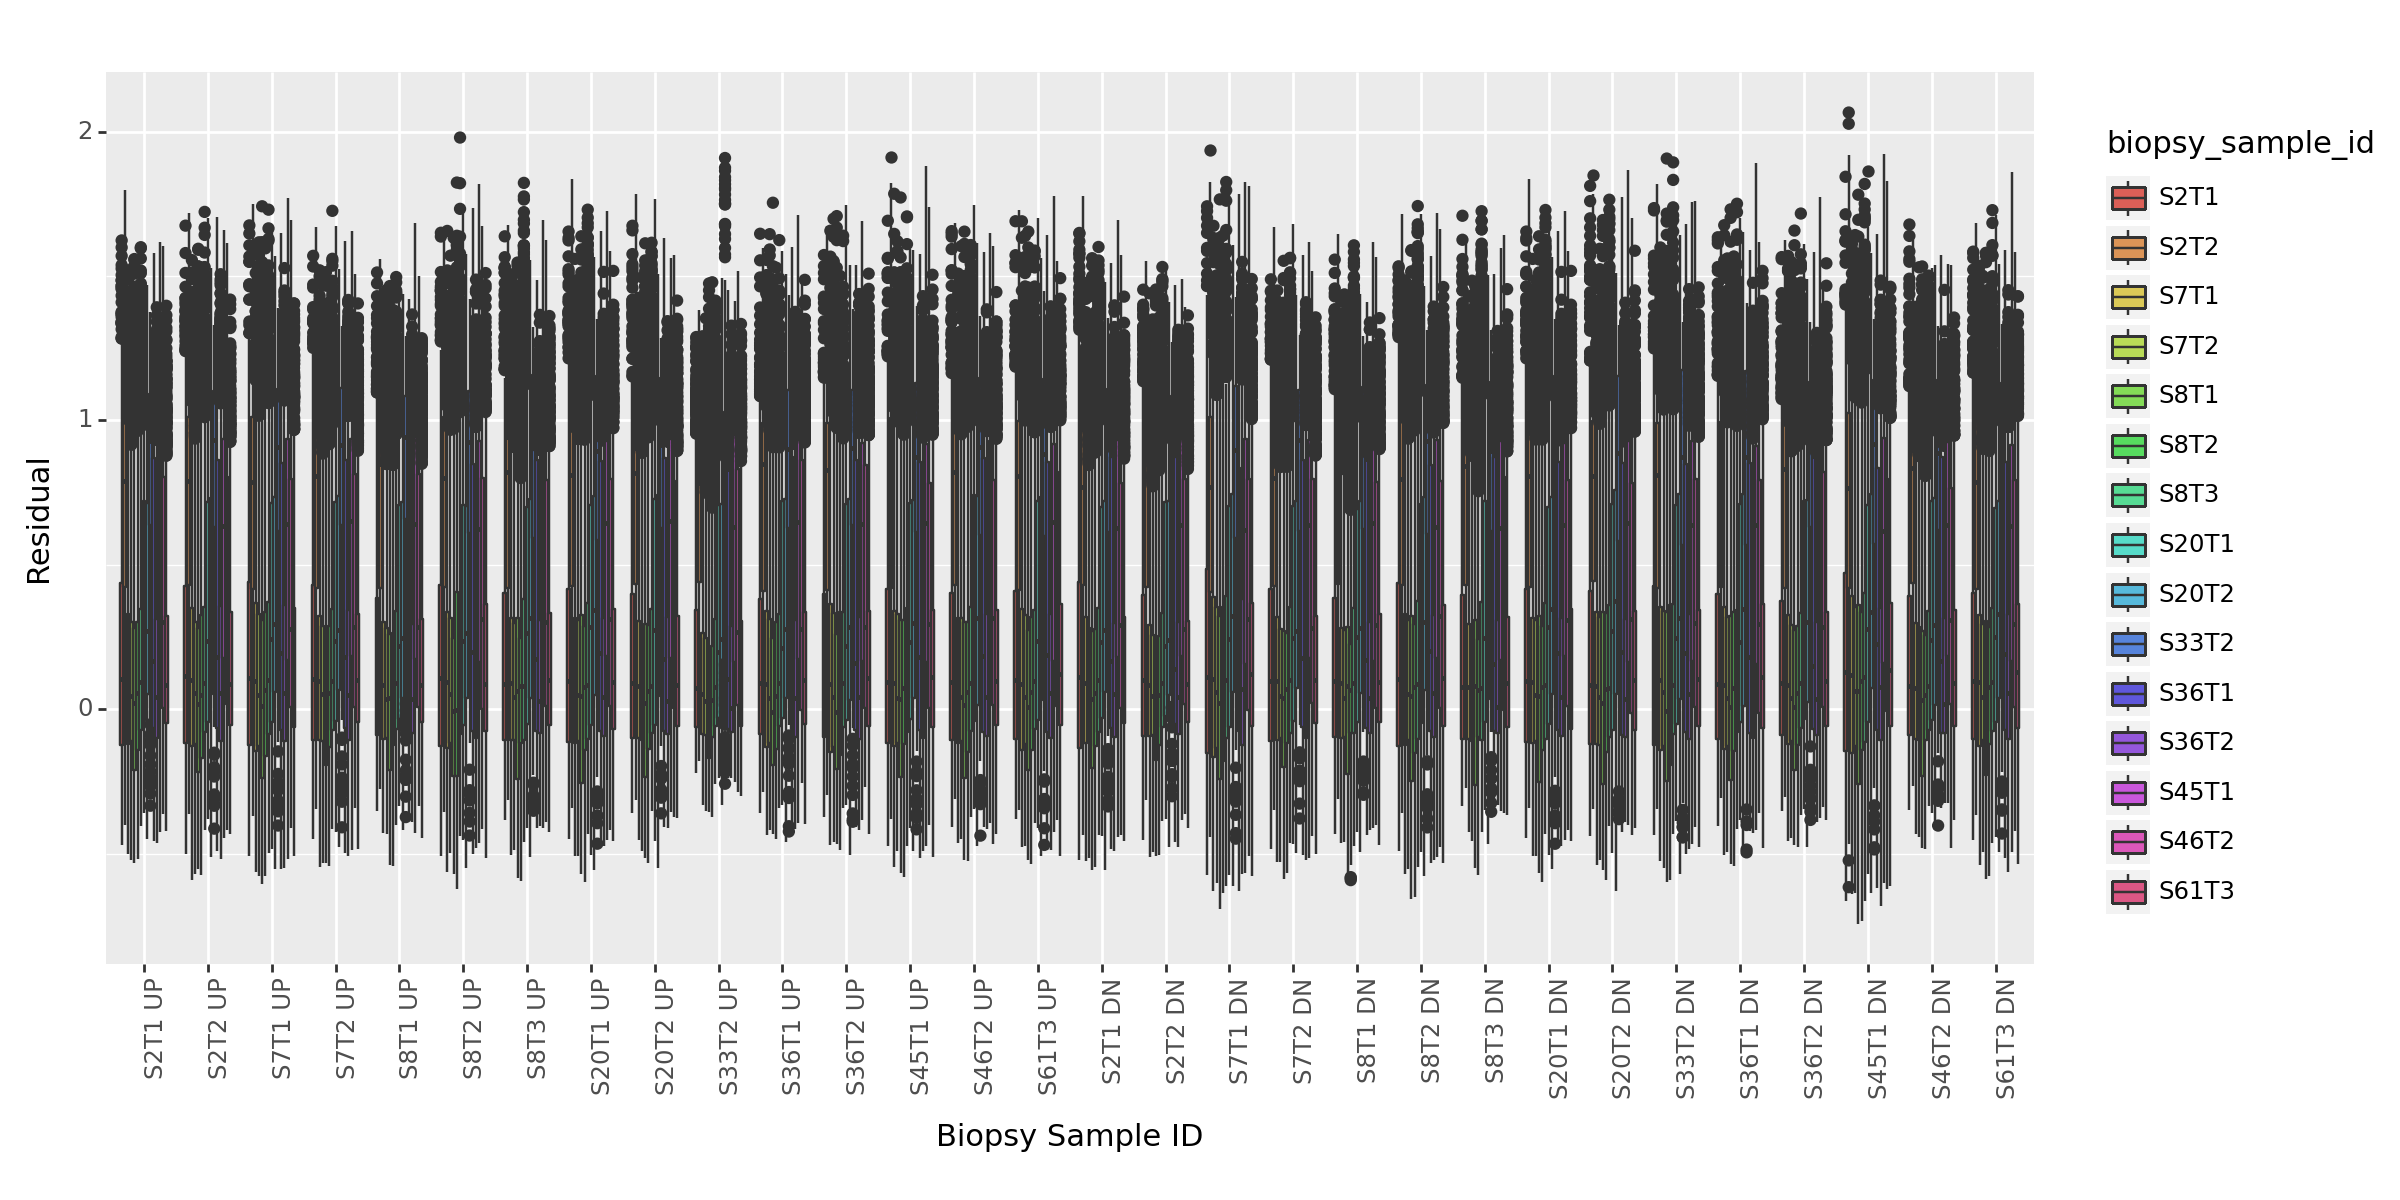

<Figure Size: (1200 x 600)>

In [157]:
(pn.ggplot(tidy_resids_updn, pn.aes(x = 'gene set', y = 'residual', fill = 'biopsy_sample_id')) +
 pn.geom_boxplot() +
#  pn.geom_violin() + 
#  pn.guides() +
 pn.theme(axis_text_x = pn.element_text(angle = 90, vjust = 1, hjust=0))+
 pn.xlab("Biopsy Sample ID") + 
 pn.ylab("Residual") +
pn.theme(figure_size=(12,6)))

In [164]:
tidy_resids_updn['Mean Squared Error'] = tidy_resids_updn['residual'].map(lambda x: x**2)
mse_updn = tidy_resids_updn.loc[:, ['biopsy_sample_id', 'Mean Squared Error', 'gene set']].groupby(
    by=['biopsy_sample_id', 'gene set'], axis=0).mean()
mse_updn['biopsy_sample_id'] = [x[0] for x in mse_updn.index]
# mse_updn['gene set'] = [x[1].split("_")[0] + " " + x[1].split("_")[-1].upper() for x in  mse_updn.index]
mse_updn['gene set'] = [x[1].split("_")[0]  for x in  mse_updn.index]

ordering = ['S2T1 UP','S2T2 UP','S7T1 UP','S7T2 UP','S8T1 UP','S8T2 UP','S8T3 UP','S20T1 UP','S20T2 UP','S33T2 UP',
     'S36T1 UP','S36T2 UP','S45T1 UP','S46T2 UP','S61T3 UP','S2T1 DN','S2T2 DN','S7T1 DN','S7T2 DN','S8T1 DN',
     'S8T2 DN','S8T3 DN','S20T1 DN','S20T2 DN','S33T2 DN','S36T1 DN','S36T2 DN','S45T1 DN','S46T2 DN','S61T3 DN'
 ]
set_ordered = pd.CategoricalDtype(ordering, ordered=True)
# mse_updn['gene set'] = mse_updn['gene set'].astype(set_ordered)


C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\917653984.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\917653984.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [163]:
mse_updn = mse_updn.reset_index(drop = True)
mse_updn.groupby(by = ['gene set'], axis = 0).mean()

C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\1266180474.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\1266180474.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


TypeError: agg function failed [how->mean,dtype->object]

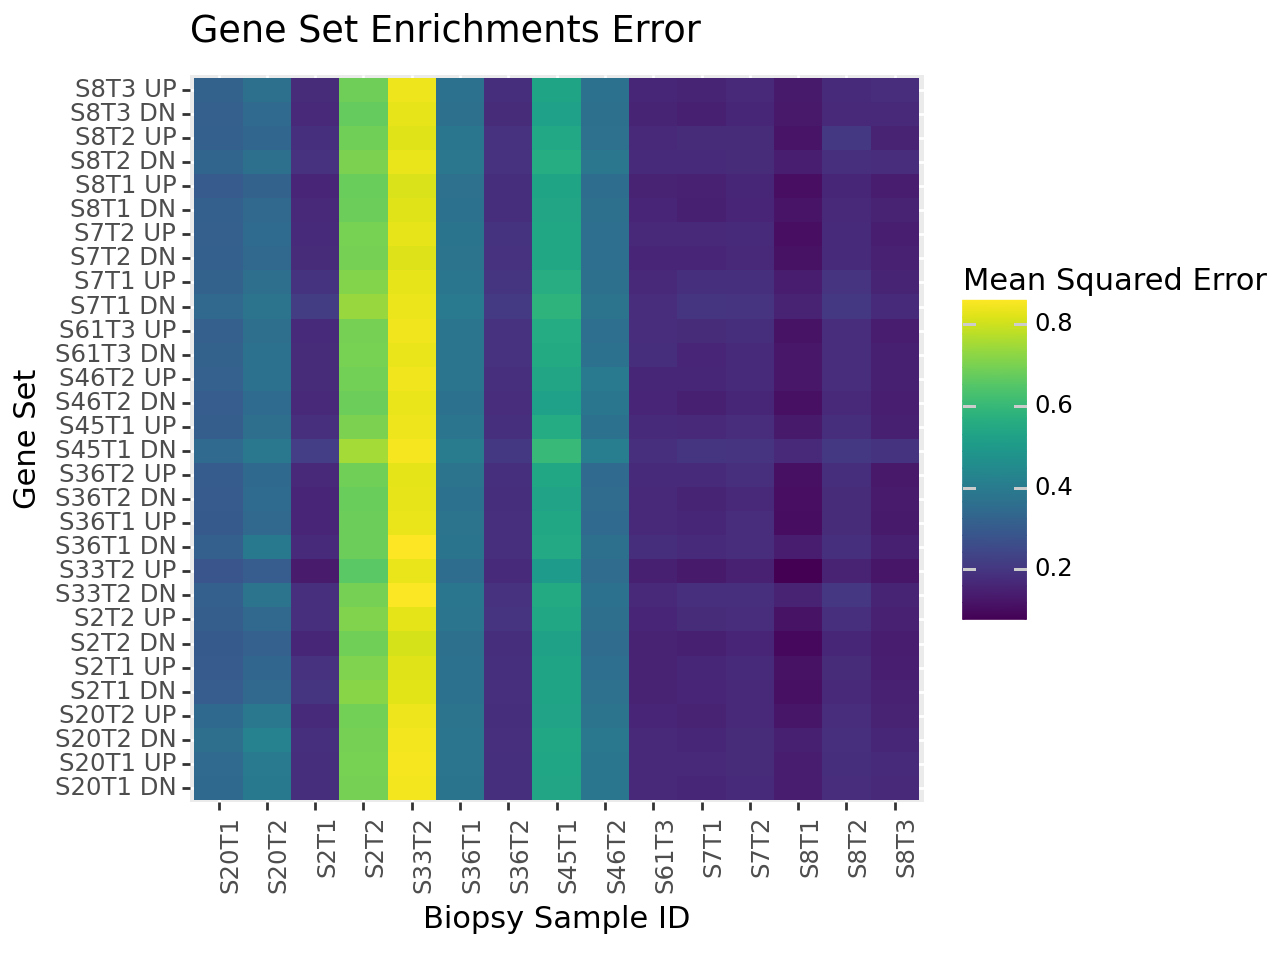

<Figure Size: (640 x 480)>

In [165]:
(
    pn.ggplot(mse_updn, pn.aes(x='biopsy_sample_id', y = 'gene set', fill = 'Mean Squared Error')) +
    pn.geom_tile() + 
    pn.theme(axis_text_x = pn.element_text(angle = 90, vjust = 1, hjust=0)) +
    pn.xlab("Biopsy Sample ID") + 
    pn.ylab("Gene Set") + 
    pn.ggtitle("Gene Set Enrichments Error") #+ 
    # pn.guides( pn.guide_legend(title = "Mean Squared Error"))
    # pn.scales.scale_fill_distiller()
    # pn.scales.scale_fill_gradient(low = 'white', high = 'purple') + 
)

In [166]:
orig_updn['biopsy_sample_id'].value_counts()

biopsy_sample_id
S36T2    4276
S36T1    4104
S8T3     2942
S7T2     2571
S8T1     2523
S45T1    2144
S7T1     1778
S2T2     1756
S8T2     1752
S2T1     1658
S61T3    1459
S20T2    1443
S20T1    1329
S46T2    1110
S33T2     559
Name: count, dtype: int64

In [117]:
tidy_resids_updn['Squared Error'] = tidy_resids_updn['residual'].map(lambda x: x**2)
tidy_resids_updn['Absolute Error'] = tidy_resids_updn['residual'].map(abs)
# means_updn = tidy_resids_updn.loc[:, ['biopsy_sample_id', 'Squared Error', 'gene set']].groupby(
#     by=['biopsy_sample_id', 'gene set'], axis=0).mean()

print(f"S36T2 Abs Error:{tidy_resids_updn.loc[tidy_resids_updn['biopsy_sample_id'] == 'S36T2', 'Absolute Error'].mean()}")
print(f"S36T2 MSE: {tidy_resids_updn.loc[tidy_resids_updn['biopsy_sample_id'] == 'S36T2', 'Squared Error'].mean()}")

S36T2 Abs Error:0.2978427445147124
S36T2 MSE: 0.2000274583394565


In [118]:
sums_updn = tidy_resids_updn.loc[:, ['biopsy_sample_id', 'Squared Error', 'gene set']].groupby(
    by=['biopsy_sample_id', 'gene set'], axis=0).sum()

C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\2078251245.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
C:\Users\cbainton\AppData\Local\Temp\ipykernel_36168\2078251245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


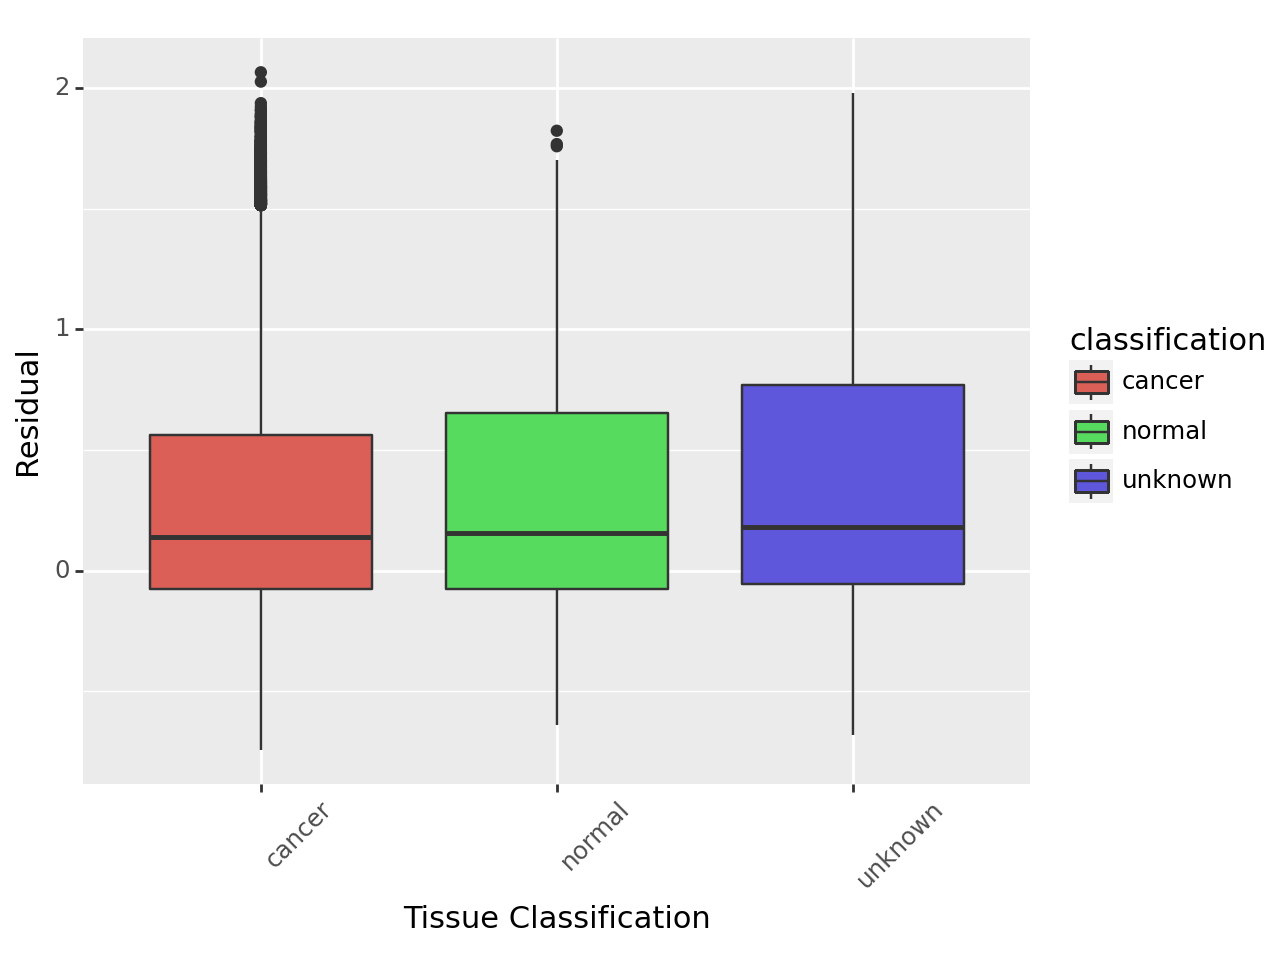

<Figure Size: (640 x 480)>

In [119]:
(pn.ggplot(tidy_resids_updn, pn.aes(x = 'classification', y = 'residual', fill = 'classification')) +
 pn.geom_boxplot() +
#  pn.geom_violin() + 
#  pn.guides() +
 pn.theme(axis_text_x = pn.element_text(angle = 45, vjust = 1, hjust=0))+
 pn.xlab("Tissue Classification") + 
 pn.ylab("Residual"))

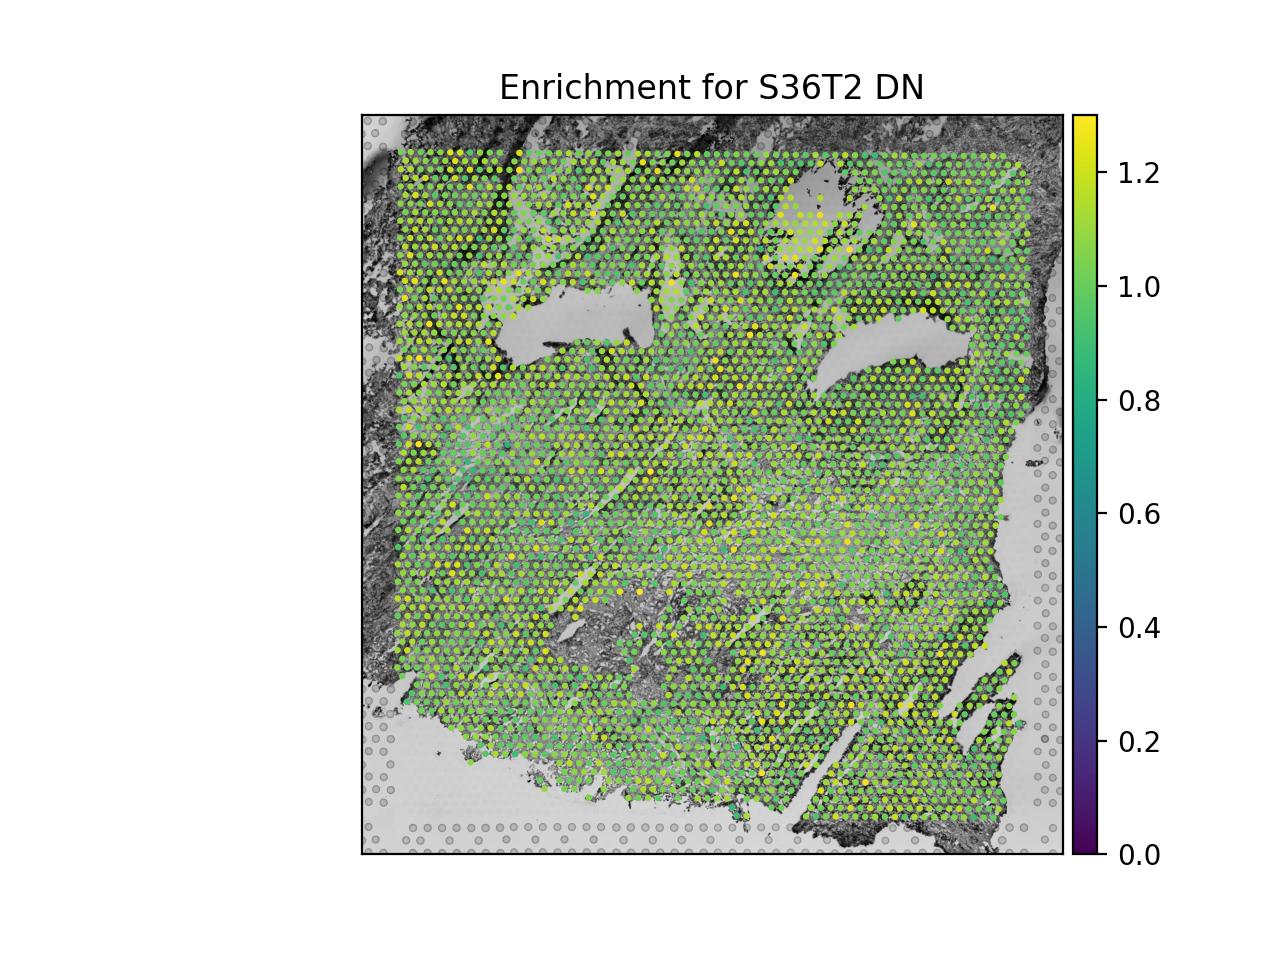

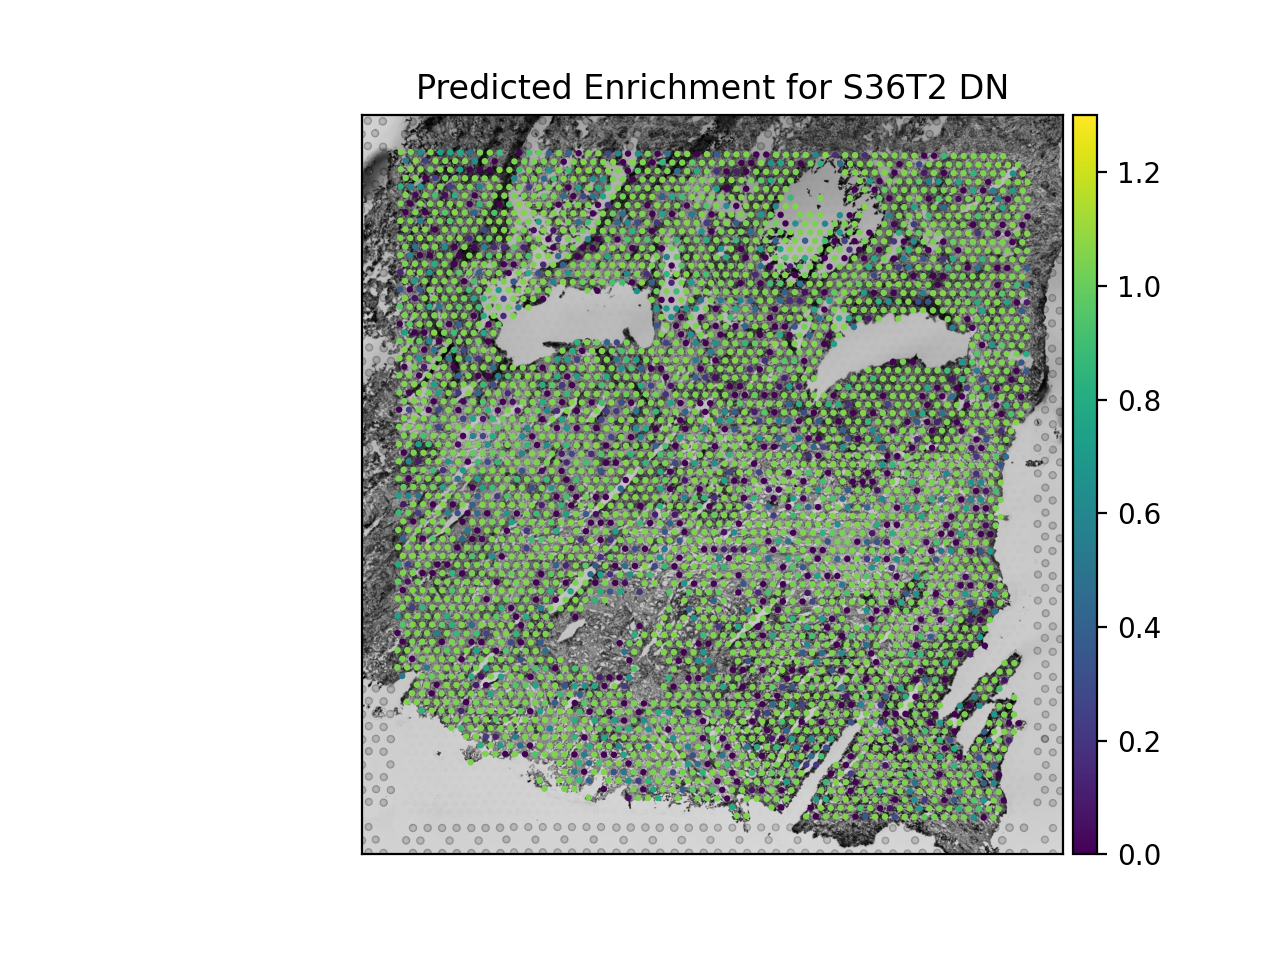

In [154]:
%config InlineBackend.figure_format = "retina"
from anndata import AnnData, read_h5ad
from scanpy.plotting import spatial
import matplotlib.pyplot as plt

s36t2 = read_h5ad("intermediate_data/enrichments_on_updn_de/S36T2_de_gene_enrichments.h5ad")
s36t2.X = s36t2.layers['nonnormalized'] # Get nonnormalized
means = s36t2.to_df().mean(axis=1)
s36t2.X = s36t2.to_df().div(means, axis = 0)

[fig0] = spatial(s36t2, bw = True, color = 'S36T2_deg_set_dn',
                     show = False,  vmin = 0, vmax =1.3)

S36T2_pred = predicted_updn.filter(regex='S36T2', axis = 0)
s36t2_pred_adata = s36t2.copy()
s36t2_pred_adata.X = S36T2_pred.loc[s36t2_pred_adata.obs_names, s36t2_pred_adata.var_names]
[fig1] = spatial(s36t2_pred_adata, bw = True, color = 'S36T2_deg_set_dn',
                     show = False, vmin = 0, vmax =1.3)

# plt.set_cmap()
for fig in [fig0, fig1]:
    fig.set_xlabel("")
    fig.set_ylabel("")
fig0.set_title("Enrichment for S36T2 DN")
fig1.set_title("Predicted Enrichment for S36T2 DN")
plt.show()

### Run 7

<Axes: >

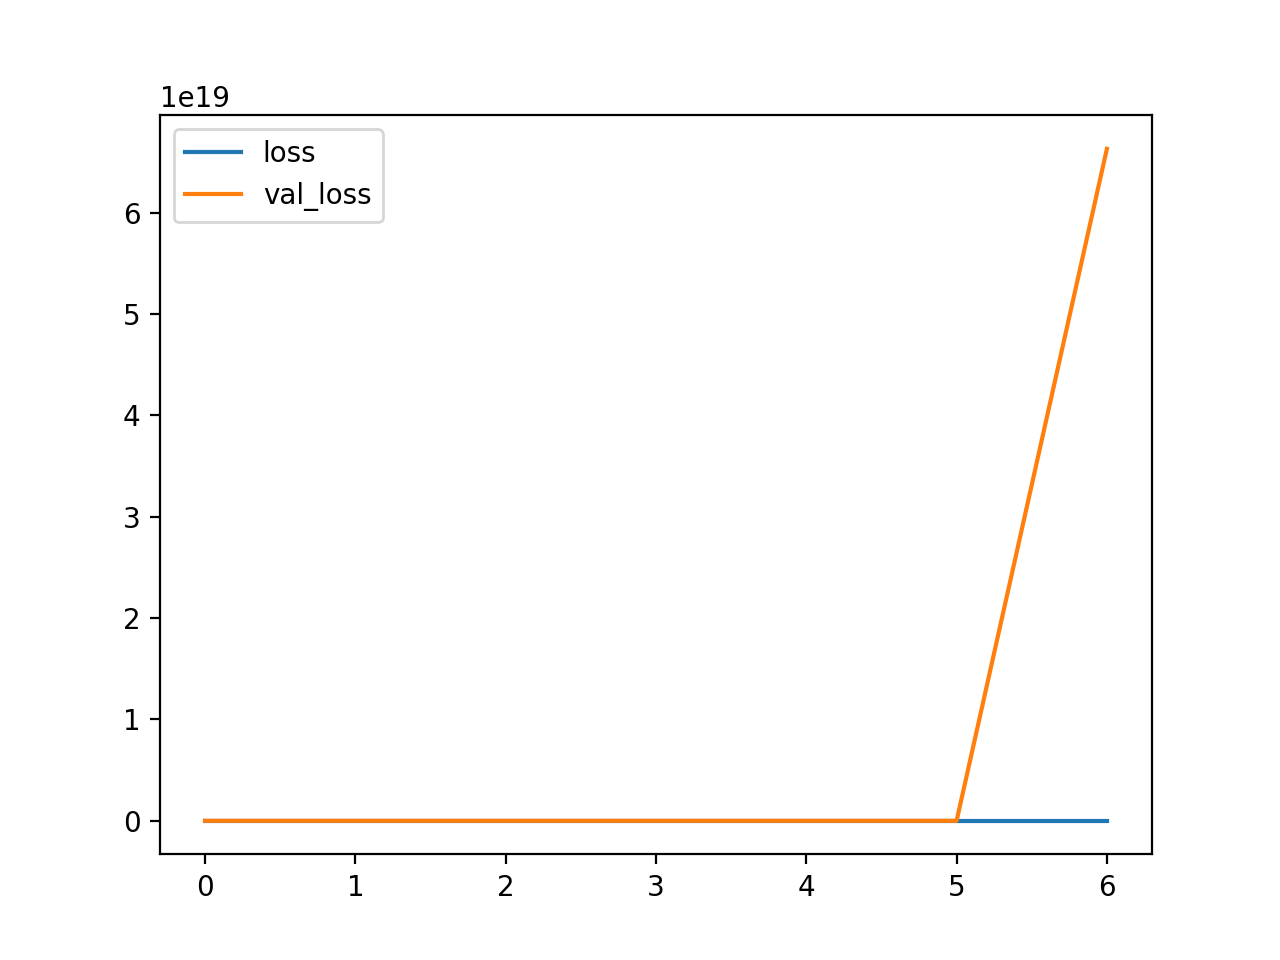

In [ ]:
model_history_path = 'models/full_nn_7_updn_dropout_history.csv'
model_path = "models/full_nn_7_updn_dropout_nn_True.keras"
history = pd.read_csv(model_history_path, index_col=0)
history.loc[:, ['loss', 'val_loss']].plot()

### Run 8

In [106]:
model_history_path = 'models/full_test_nn_8_dropout_running_history.csv'
# model_path = "models/full_nn_8_updn_dropout_nn_True.keras"
history = pd.read_csv(model_history_path, index_col=0)
history['epoch'] = list(history.index)

tidy_hist = history.loc[:, ['epoch', 'loss', 'val_loss']].melt(id_vars='epoch', var_name='Dataset', value_name='Mean Squared Error')
tidy_hist['Dataset'] = tidy_hist['Dataset'].map({"loss": "Training", "val_loss" : "Validation"})

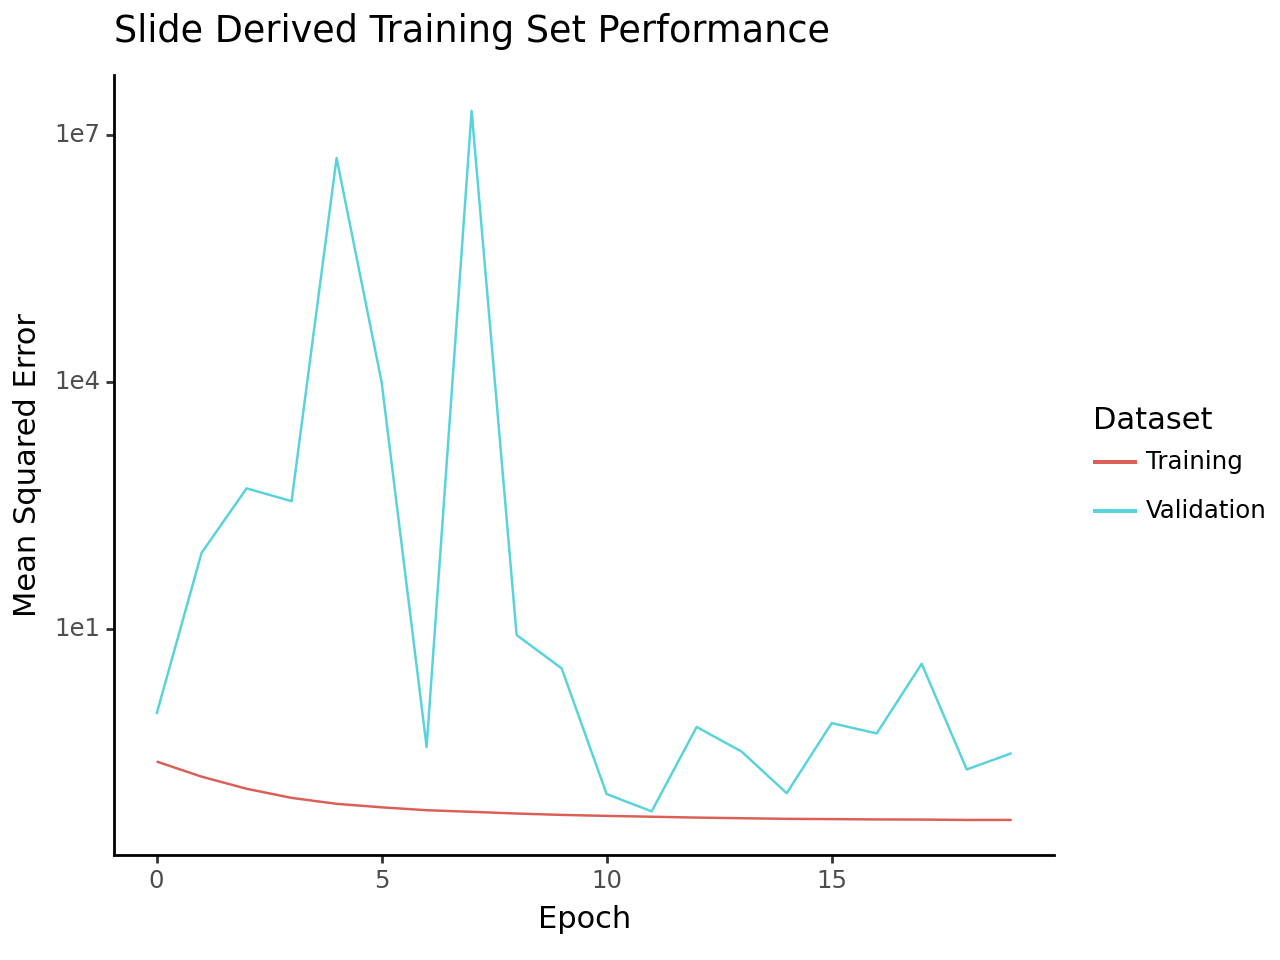

<Figure Size: (640 x 480)>

In [110]:

(
    pn.ggplot(tidy_hist, pn.aes(x = 'epoch', y = 'Mean Squared Error', color = 'Dataset')) + 
    pn.geom_line() +
    pn.ylab("Mean Squared Error") +
    pn.xlab('Epoch') + 
    pn.scale_y_log10() + 
    pn.ggtitle('Slide Derived Training Set Performance') + 
    pn.theme_classic()
)

## Loss on External Gene Sets

In [11]:
predicted_external = pd.read_csv("intermediate_data/predicted_enrichments/predicted_external/predicted_enrichments.csv", index_col = 0)
orig_external = pd.read_csv("intermediate_data/predicted_enrichments/predicted_external/orig_enrichments.csv", index_col = 0)
spot_info_external = pd.read_csv("intermediate_data/predicted_enrichments/predicted_external/orig_info.csv", index_col = 0) # SHOULD be identical

In [12]:
predicted_external['spot'] = predicted_external.index
tidy_predicted_external = predicted_external.melt(id_vars=['spot'], var_name='gene set', value_name='enrichment')
predicted_external.drop(labels='spot', inplace = True, axis=1)

orig_external['spot'] = orig_external.index
orig_external = pd.concat([orig_external, spot_info_external], axis=1)
tidy_orig_external = orig_external.melt(id_vars=['spot'] + list(spot_info_external.columns), var_name='gene set', value_name='enrichment')
orig_external.drop(labels='spot', inplace = True, axis=1)

tidy_resids_external = tidy_orig_external.drop(['enrichment'], axis=1)
tidy_resids_external['residual'] = tidy_predicted_external['enrichment'] - tidy_orig_external['enrichment']
tidy_resids_external['predicted'] = tidy_predicted_external['enrichment']
tidy_resids_external['original'] =tidy_orig_external['enrichment']
gene_set_external_renames = {'BCAT_BILD_ET_AL_DN' : 'BCAT DN',
  'BCAT_BILD_ET_AL_UP' : 'BCAT UP',
    'CORDENONSI_YAP_CONSERVED_SIGNATURE' : 'CORDENONSI YAP',
         'E2F3_UP.V1_DN': 'E2F3-U DN',
       'E2F3_UP.V1_UP' : 'E2F3-U UP',
        'KRAS.600.LUNG.BREAST_UP.V1_DN' : 'KRAS 600 L Br-U DN',
       'KRAS.600.LUNG.BREAST_UP.V1_UP' : 'KRAS 600 L Br-U UP',
         'KRAS.BREAST_UP.V1_DN' : 'KRAS Br-U DN',
       'KRAS.BREAST_UP.V1_UP' : 'KRAS Br-U UP',
         'KRAS.LUNG.BREAST_UP.V1_DN': 'KRAS L Br-U DN',
       'KRAS.LUNG.BREAST_UP.V1_UP': 'KRAS L Br-U UP',
         'MYC_UP.V1_DN' : 'MYC-U DN',
           'MYC_UP.V1_UP' : 'MYC-U UP',
       'SRC_UP.V1_DN' : 'SRC-U DN',
         'SRC_UP.V1_UP' : 'SRC-U UP',
           'TGFB_UP.V1_DN' : 'TGFB-U DN',
            'TGFB_UP.V1_UP' : 'TGFB-U UP'
}
tidy_resids_external['gene set'] = tidy_resids_external['gene set'].map(gene_set_external_renames)

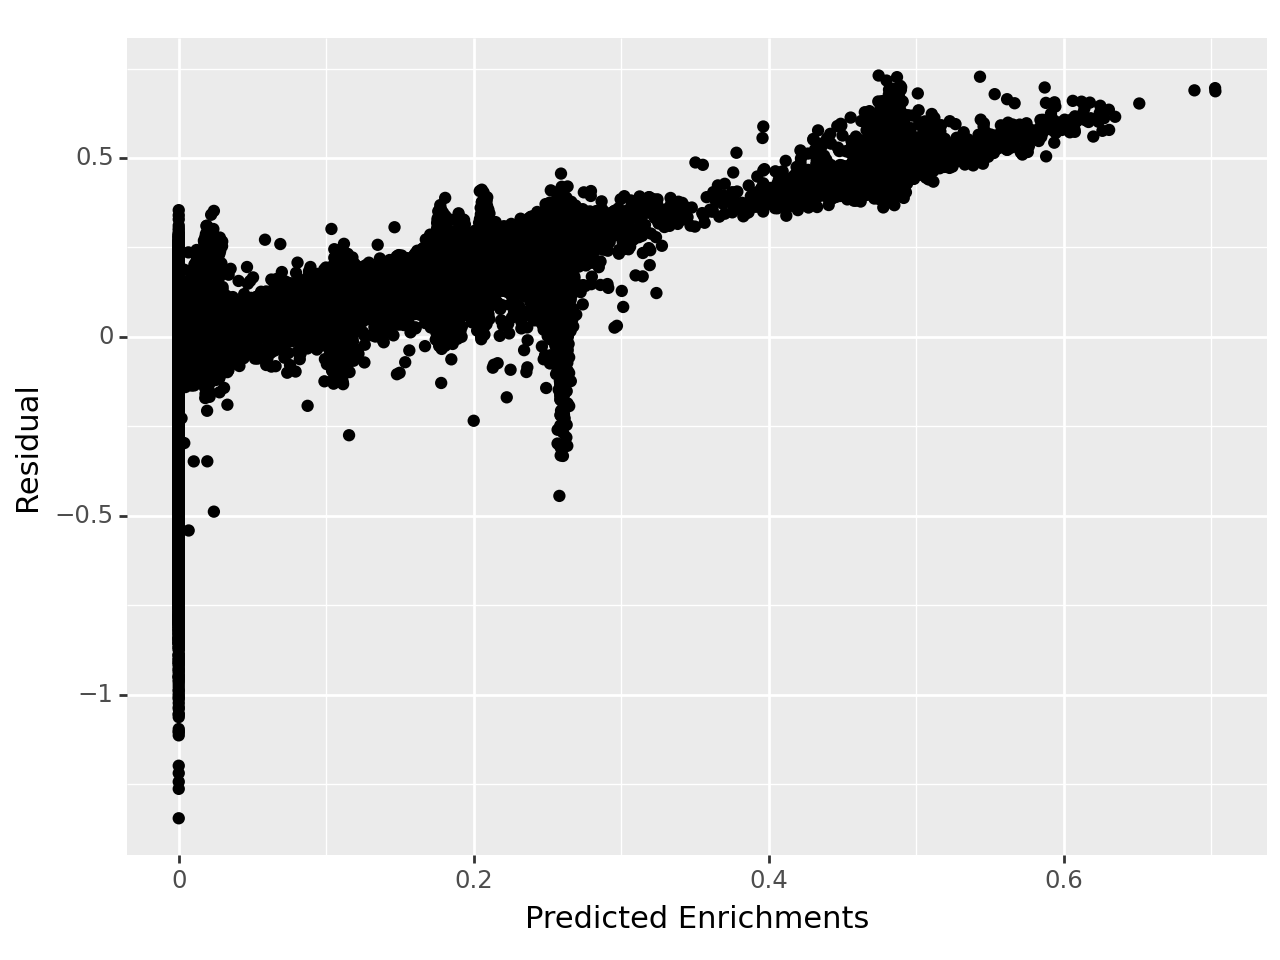

<Figure Size: (640 x 480)>

In [4]:
(
    pn.ggplot(tidy_resids_external, pn.aes(x = 'predicted', y = 'residual')) + 
        pn.geom_point() + 
        pn.xlab("Predicted Enrichments") + 
        pn.ylab("Residual")
)

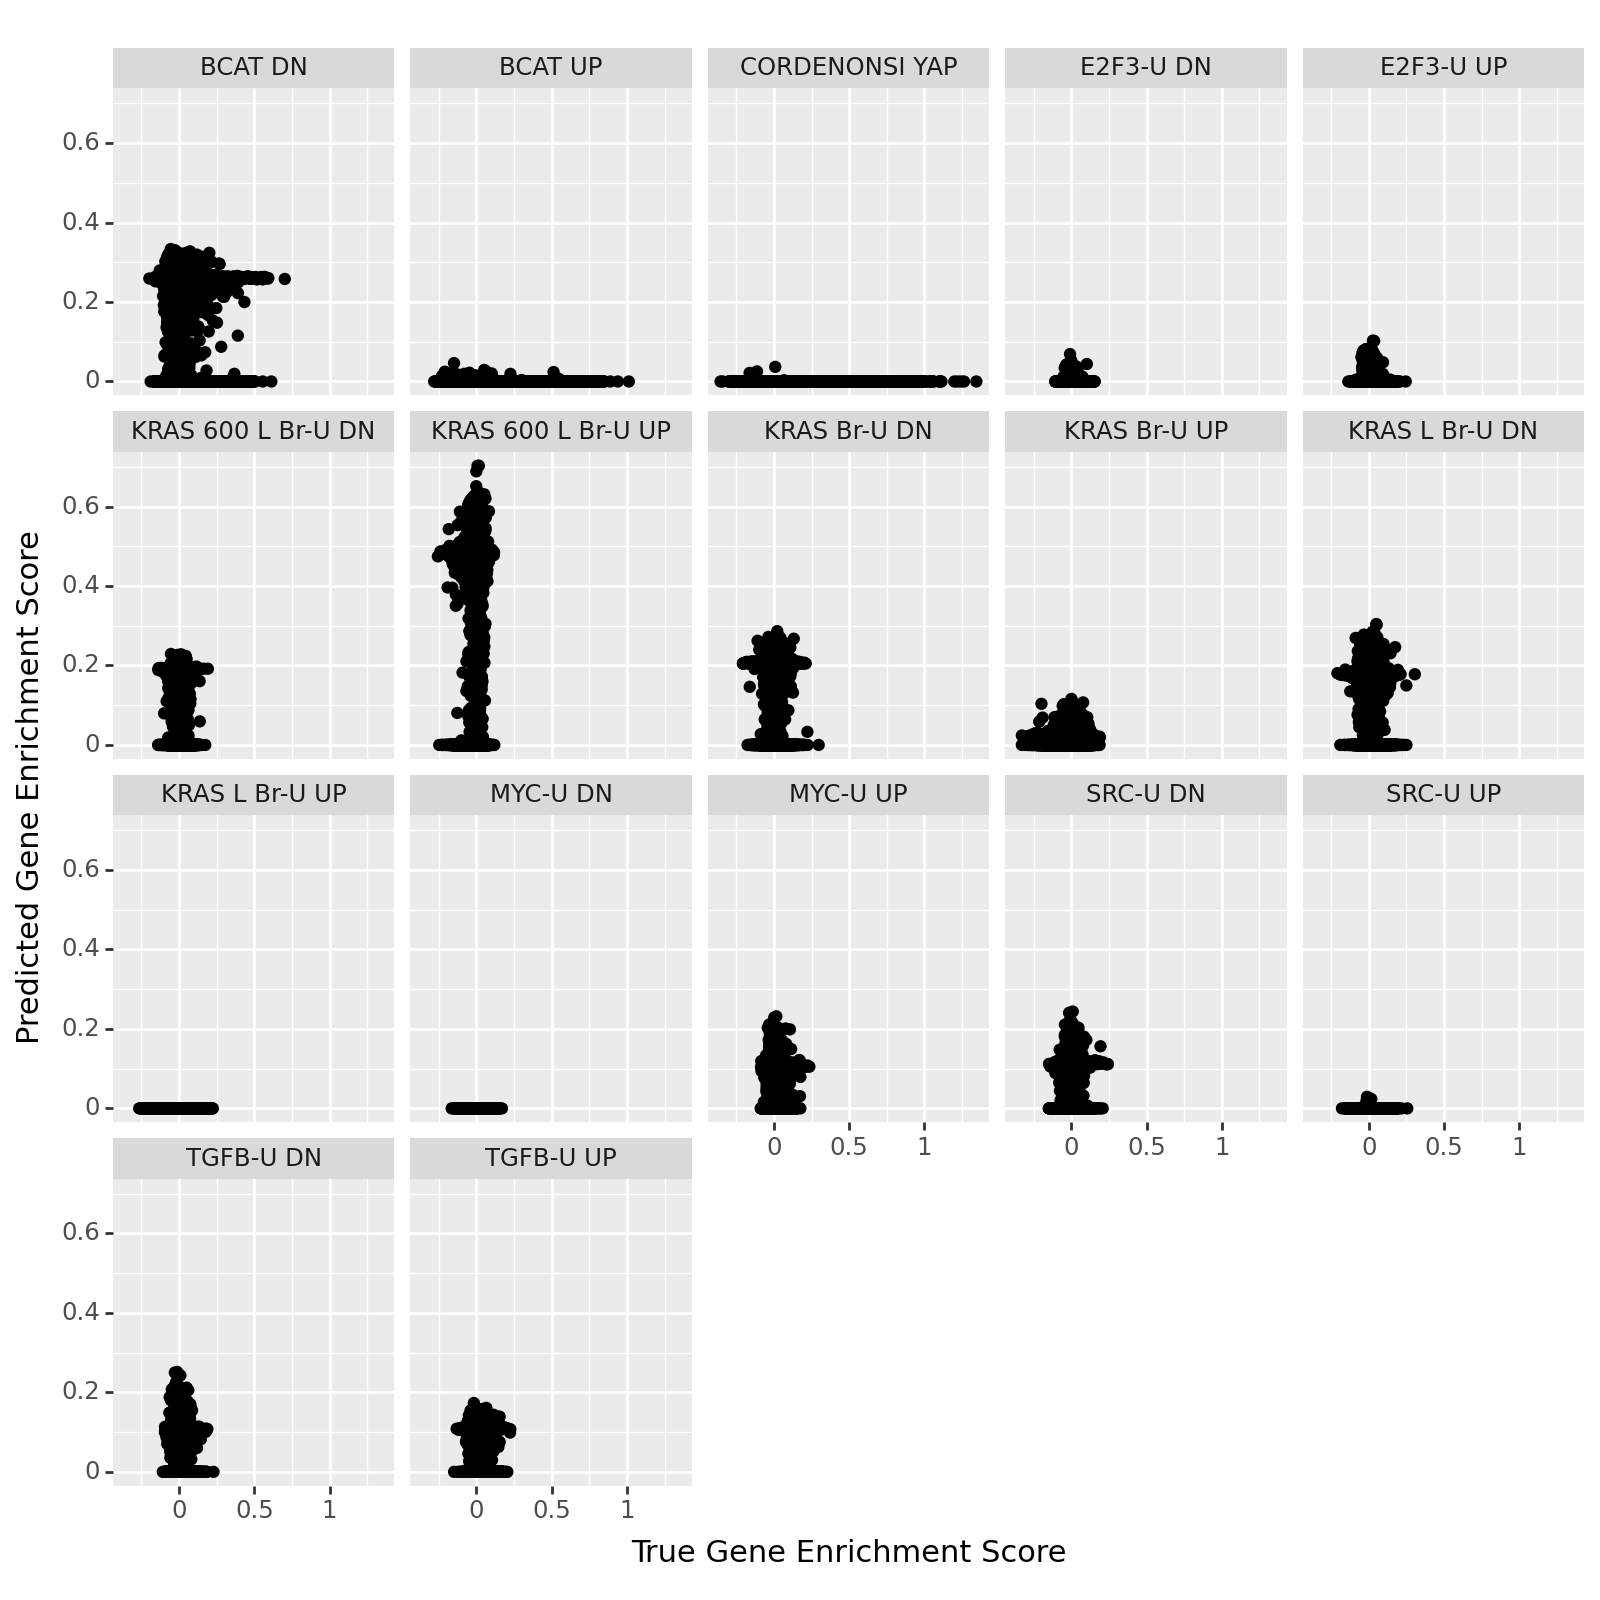

<Figure Size: (800 x 800)>

In [14]:
(
    pn.ggplot(tidy_resids_external, pn.aes(x = 'original', y = 'predicted')) + 
        pn.geom_point() + 
        pn.xlab("True Gene Enrichment Score") + 
        pn.ylab("Predicted Gene Enrichment Score") +
        pn.facet_wrap("gene set") +
        pn.theme(figure_size=(8, 8))
)

#### Loss by group

C:\Users\cbainton\AppData\Local\Temp\ipykernel_14256\3672645515.py:3: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.


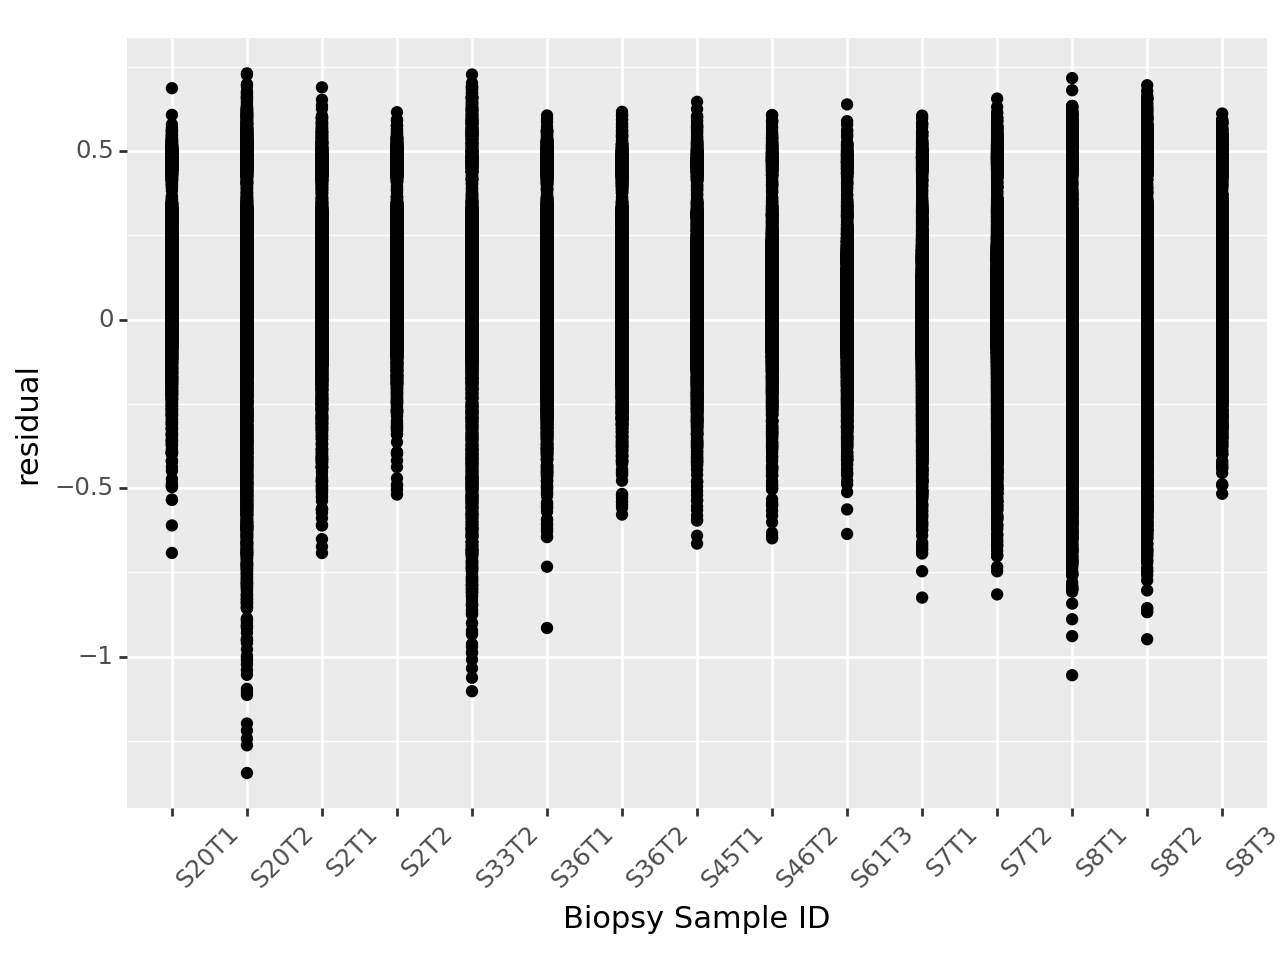

<Figure Size: (640 x 480)>

In [13]:
(pn.ggplot(tidy_resids_external, pn.aes(x = 'biopsy_sample_id', y = 'residual')) +
 pn.geom_point() + 
 pn.theme(axis_text_x = pn.element_text(angle = 45, vjust = 1, hjust=0)) +
 pn.xlab("Biopsy Sample ID") +
 pn.ylab("Residual"))

In [23]:
tidy_resids_external['Mean Squared Error'] = tidy_resids_external['residual'].map(lambda x: x**2)
mse_external = tidy_resids_external.loc[:, ['biopsy_sample_id', 'Mean Squared Error', 'gene set']].groupby(
    by=['biopsy_sample_id', 'gene set'], axis=0).mean()
mse_external['biopsy_sample_id'] = [x[0] for x in mse_external.index]
# mse_external['gene set'] = [x[1].split("_")[0] + " " + x[1].split("_")[-1] for x in  mse_external.index]
mse_external['gene set'] = [x[1] for x in  mse_external.index]
# mse_external.rename([])

C:\Users\cbainton\AppData\Local\Temp\ipykernel_51716\3881228172.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.


Mean Squared Error biopsy_sample_id  \
biopsy_sample_id gene set                                              
S20T1            BCAT DN                   0.078140            S20T1   
                 BCAT UP                   0.024733            S20T1   
                 CORDENONSI YAP            0.015960            S20T1   
                 E2F3-U DN                 0.000392            S20T1   
                 E2F3-U UP                 0.000366            S20T1   
...                                             ...              ...   
S8T3             MYC-U UP                  0.010869             S8T3   
                 SRC-U DN                  0.011907             S8T3   
                 SRC-U UP                  0.000724             S8T3   
                 TGFB-U DN                 0.010479             S8T3   
                 TGFB-U UP                 0.012222             S8T3   

                                                gene set  
biopsy_sample_id gene set                                 
S20T1            BCAT DN                (S20T1, BCAT DN)  
                 BCAT UP                (S20T1, BCAT UP)  
                 CORDENONSI YAP  (S20T1, CORDENONSI YAP)  
                 E2F3-U DN            (S20T1, E2F3-U DN)  
                 E2F3-U UP            (S20T1, E2F3-U UP)  
...                                                  ...  
S8T3             MYC-U UP               (S8T3, MYC-U UP)  
                 SRC-U DN               (S8T3, SRC-U DN)  
                 SRC-U UP               (S8T3, SRC-U UP)  
                 TGFB-U DN             (S8T3, TGFB-U DN)  
                 TGFB-U UP             (S8T3, TGFB-U UP)  

[255 rows x 3 columns]

In [21]:
(
    pn.ggplot(mse_external, pn.aes(x='biopsy_sample_id', y = 'gene set', fill = 'Mean Squared Error')) +
    pn.geom_tile() + 
    pn.theme(axis_text_x = pn.element_text(angle = 90, vjust = 1, hjust=0)) +
    pn.xlab("Biopsy ID") + 
    pn.ylab("Gene Set") + 
    pn.ggtitle("Gene Set Enrichments Error") #+ 
    # pn.guides( pn.guide_legend(title = "Mean Squared Error"))
    # pn.scales.scale_fill_distiller()
    # pn.scales.scale_fill_gradient(low = 'white', high = 'purple') + 
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()